In this file we will use a Neural Network to classify speakers. We will use a RNN with the melspectrogam coefficients feature, that proved to be effective in the machine learning section and is better suited than the melspec feature because the images are smaller and the computational time will be shorter. This time we wont flatten the spectogram because we want to mantain the temporal aspect of the feature

**Importing libraries**

In [1]:
import os
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import wavfile as wav
from librosa.feature import melspectrogram, mfcc

# Had to use pip install tensorflow
from tensorflow import keras
from tensorflow.keras.models import load_model

import re

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from scikitplot.metrics import plot_confusion_matrix 


Setting path variable:

In [2]:
path = os.getcwd() + '\\data\\'
print(path)

c:\Users\Emili\DSIM_project\VER\data\


### **Loading data**

In [3]:
def load_data(feature_extractor, train_size=0.8):
  
  # Note: train size must be 0.8 (see preprocessing.ipynb)
  train = []
  X_train = []
  y_train = []

  test = []
  X_test = []
  y_test = []
  
  unauth_split = train_size/(23-22*train_size)

  random.seed(10) # For reproducibility

  
  # Authorized speaker
  track_num = 0
  tracks = os.listdir(path + 'auth_speaker')
  random.shuffle(tracks)
  for track in tracks:
    track_num = track_num + 1
    _, signal = wav.read(path + 'auth_speaker\\' + track)
    if track_num <=np.floor(train_size*len(tracks)):
      train.append((feature_extractor(signal), np.int32(0)))
    else:
        test.append((feature_extractor(signal), np.int32(0)))
        
  # Impostor speaker
  for speaker in os.listdir(path + 'unauth_speakers'):
    track_num = 0
    tracks = os.listdir(path + 'unauth_speakers\\' + speaker)
    random.shuffle(tracks)
    for track in tracks:
      track_num = track_num + 1
      _, signal = wav.read(path + 'unauth_speakers\\' + speaker + '\\' + track)
      if track_num <=np.floor(unauth_split*len(tracks)):
        train.append((feature_extractor(signal), np.int32(1)))
      else:
        test.append((feature_extractor(signal), np.int32(1)))
          
  random.shuffle(train)
  random.shuffle(test)
  
  # Separate features and labels
  X_train = [row[0] for row in train]
  y_train = np.array([row[1] for row in train])
  X_test = [row[0] for row in test]
  y_test = np.array([row[1] for row in test])


  # Normalize          
  eps = 0.001
  X_train = np.array(X_train)
  X_train_mean = X_train.mean(axis=0)
  X_train_std = X_train.std(axis=0)
  X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
  X_train = [row for row in X_train]
  X_train = np.array(X_train)
  X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]
  X_test = np.array(X_test)

  return X_train, X_test, y_train, y_test


def feats_mfcc(input, rate = 8000):
  input = mfcc(y = input*1.0, sr = rate)
  output = np.transpose(input)
  return output

In [4]:
X_train, X_test, y_train, y_test = load_data(feature_extractor=feats_mfcc, train_size=0.8)

### **Gate Recurrent Unit (GRU) Neural Network**

Just one layer of GRU, followed by a dense layer with softmax activation was enough to get great performances on the test set thanks to the abundance of data

In [5]:
features_input = keras.Input((157, 20), batch_size=64)
x = keras.layers.GRU(16, return_sequences=False, dropout=0.2)(features_input)
output = keras.layers.Dense(2, activation='softmax')(x)
net = keras.Model(features_input, output)

In [6]:
net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(64, 157, 20)]           0         
                                                                 
 gru (GRU)                   (64, 16)                  1824      
                                                                 
 dense (Dense)               (64, 2)                   34        
                                                                 
Total params: 1,858
Trainable params: 1,858
Non-trainable params: 0
_________________________________________________________________


In [7]:
net.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop',
            metrics=['accuracy'])

In [8]:
callback = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.01,
    patience=10,
    baseline=None,
    restore_best_weights=True,
)

In [9]:
# Train model
history = net.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks = [callback]
)

Epoch 1/30
71/71 [==============================] - 7s 74ms/step - loss: 0.6931 - accuracy: 0.5743 - val_loss: 0.6025 - val_accuracy: 0.6699
Epoch 2/30
71/71 [==============================] - 6s 90ms/step - loss: 0.5166 - accuracy: 0.7497 - val_loss: 0.4930 - val_accuracy: 0.7584
Epoch 3/30
71/71 [==============================] - 8s 115ms/step - loss: 0.4293 - accuracy: 0.7990 - val_loss: 0.4278 - val_accuracy: 0.8004
Epoch 4/30
71/71 [==============================] - 9s 128ms/step - loss: 0.3384 - accuracy: 0.8480 - val_loss: 0.3488 - val_accuracy: 0.8600
Epoch 5/30
71/71 [==============================] - 8s 115ms/step - loss: 0.2458 - accuracy: 0.9039 - val_loss: 0.3107 - val_accuracy: 0.8971
Epoch 6/30
71/71 [==============================] - 8s 119ms/step - loss: 0.1660 - accuracy: 0.9462 - val_loss: 0.2258 - val_accuracy: 0.9362
Epoch 7/30
71/71 [==============================] - 8s 107ms/step - loss: 0.1256 - accuracy: 0.9669 - val_loss: 0.1894 - val_accuracy: 0.9483
Epoch 8/

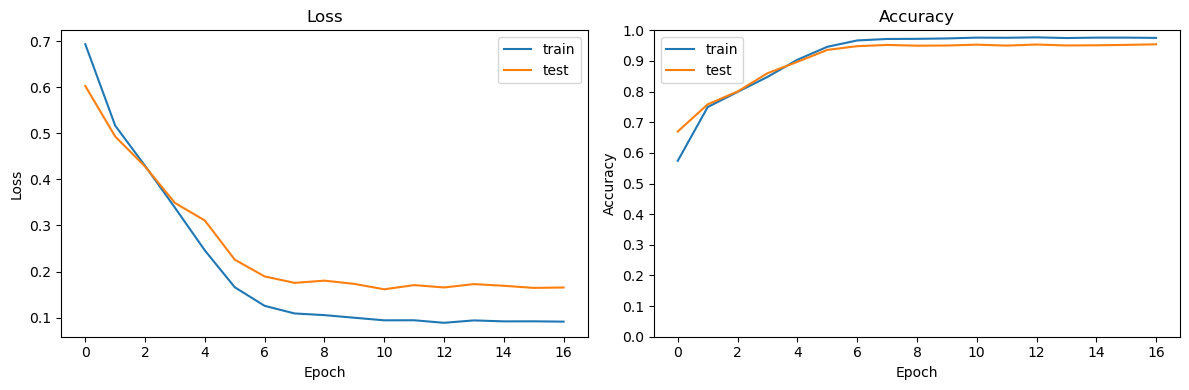

In [10]:
# Visualization of the learning curves
# Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])
plt.xticks(np.arange(0, len(history.history['loss']), 2),
           np.arange(0, len(history.history['loss']), 2, dtype=int))
plt.title('Loss')

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])
plt.title('Accuracy')
plt.yticks(np.arange(0, 1.1, 0.1))  # Set y-axis tick marks from 0 to 1 with a step of 0.1
plt.xticks(np.arange(0, len(history.history['accuracy']), 2),
           np.arange(0, len(history.history['accuracy']), 2, dtype=int))

plt.tight_layout()
plt.show()

In [12]:
def get_classification_report(y_test, y_pred):

    report = classification_report(y_test, y_pred, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    df_classification_report = df_classification_report.round(3)
    df_classification_report = df_classification_report.drop(['weighted avg'])
    df_classification_report['support'] = df_classification_report['support'].astype(int)
    df_classification_report['accuracy'] = np.nan
    df_classification_report = df_classification_report[['accuracy', 'precision', 'recall', 'f1-score', 'support']]
    df_classification_report['accuracy']['macro avg']= df_classification_report['precision']['accuracy']
    df_classification_report = df_classification_report.drop(['accuracy'], axis=0)
    df_classification_report.rename({'macro avg': 'average'}, axis=0, inplace=True)
    df_classification_report.rename(index={'0': 'authorized', '1': 'impostor'}, inplace=True)
    return df_classification_report

In [13]:

yc_pred = net.predict(X_test)
y_pred = np.argmax(yc_pred, axis=1)
classification_report_gru = get_classification_report(y_test, y_pred)
print('\nClassification report for GRU (test set):')
classification_report_gru

215/215 [==============================] - 2s 9ms/step

Classification report for GRU (test set):


,accuracy,precision,recall,f1-score,support
authorized,NaN,0.446,0.990,0.615,286
impostor,NaN,1.000,0.946,0.972,6578
average,0.948,0.723,0.968,0.793,6864


Really similar results to the KNN performances

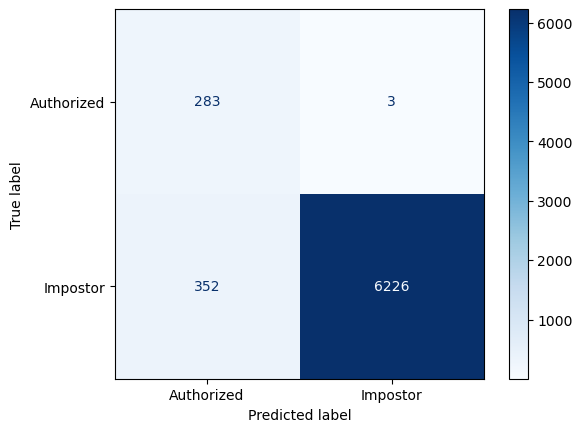

In [14]:
label_names = ['Authorized', 'Impostor']

cm = confusion_matrix(y_test, y_pred)
 
ConfusionMatrixDisplay(cm, display_labels=label_names).plot(values_format='d',
                                                            cmap=plt.cm.Blues);

This model is just slighlty worse than the KNN because it has more unauthorized users classified as authorized

In [234]:
classification_report_gru.to_csv(os.getcwd() + '\\GRU_performances.csv',
                                index = True)

In [180]:
net.save('GRU_VER.h5')
